# 모델링 및 학습

### 간단한 전처리
간단한 추천 시스템을 구현하기 위해 lightgbm으로 모델을 돌려봤습니다.  
모델을 돌리기 전에 간단한 전처리를 했습니다. 
- 카테고리 데이터의 경우: LabelEncoder후에 StandardScaler로 정규화
- 연속적인 데이터의 경우: StandardScaler로 정규화

### 모델 학습
- lightgbm으로 학습합니다. 
- feature의 중요도를 시각화 합니다. 
- 정확도를 평가합니다. 

## 간단한 전처리

In [275]:
import pandas as pd
import lightgbm as lgb
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [237]:
data_df = pd.read_csv('./new_data/df_data.csv')

In [238]:
data_df.shape

(18284, 15)

In [239]:
data_df

,고객,행동,경과시간,키워드,총뷰,총세션,경로,장비,등급,구매일자,구매금액,구매수량,성별,나이,소분류
0,72147,6,312745,NaN,28,357,DIRECT,mobile_web,3.0,20190701,1000,1,F,40.0,기능성 츄잉 잇몸
1,22398,6,1317216,NaN,27,1348,PUSH,mobile_web,2.0,20190701,3380,1,F,40.0,라멘스
2,23142,6,1394508,NaN,63,1445,DIRECT,PC,5.0,20190701,2750,1,F,40.0,라멘스
3,23573,6,2006724,NaN,64,2007,DIRECT,PC,5.0,20190701,2255,1,F,50.0,라멘스
4,51290,6,523487,NaN,21,2119,DIRECT,unknown,2.0,20190701,7490,1,F,30.0,냉동 만두
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18279,67256,6,834448,NaN,77,2411,DIRECT,unknown,3.0,20190717,35600,4,M,40.0,이어 셸
18280,10587,6,647734,NaN,60,2202,DIRECT,unknown,2.0,20190717,10900,1,F,50.0,포장김치
18281,68390,6,687858,NaN,21,715,DIRECT,unknown,5.0,20190717,29800,2,F,40.0,고구마
18282,10587,6,647734,NaN,60,2202,DIRECT,unknown,2.0,20190717,14900,1,F,50.0,포장김치


In [240]:
data_df.columns

Index(['고객', '행동', '경과시간', '키워드', '총뷰', '총세션', '경로', '장비', '등급', '구매일자',
       '구매금액', '구매수량', '성별', '나이', '소분류'],
      dtype='object')

In [260]:
COLUMNS = ['고객', '행동', '경과시간',  '키워드', '총뷰', '총세션', '경로','장비', '등급', 
           '구매일자', '구매금액', '구매수량', '성별', '나이']

CATEGORICAL_COLUMNS = ["고객", "행동", "키워드", "경로", "장비", "등급" ,"구매일자","구매수량", "성별", "나이", '소분류']

CONTINUOUS_COLUMNS = ["경과시간","총뷰", "총세션", "구매금액"]

In [255]:
data_df["소분류"] = data_df["소분류"].astype(str)

In [256]:
for c in CATEGORICAL_COLUMNS:
    le = LabelEncoder()
    data_df[c] = le.fit_transform(data_df[c])

In [257]:
data_df.head()

,고객,행동,경과시간,키워드,총뷰,총세션,경로,장비,등급,구매일자,구매금액,구매수량,성별,나이,소분류
0,1849,0,-0.973269,0,-0.564853,-0.982693,0,1,2,0,-0.313833,1,0,3,53
1,514,0,-0.191089,12190,-0.596968,-0.274069,4,1,1,0,-0.160512,1,0,3,119
2,535,0,-0.130901,12189,0.559173,-0.204708,0,0,4,0,-0.201097,1,0,3,119
3,547,0,0.345830,12188,0.591288,0.197155,0,0,4,0,-0.232985,1,0,4,119
4,1291,0,-0.809164,12187,-0.789658,0.277242,0,2,1,0,0.104258,1,0,2,88


In [261]:
scaler = StandardScaler()
data_df[COLUMNS] = scaler.fit_transform(data_df[COLUMNS])
data_df.head()

,고객,행동,경과시간,키워드,총뷰,총세션,경로,장비,등급,구매일자,구매금액,구매수량,성별,나이,소분류
0,1.757692,-0.029595,-0.973269,-1.731956,-0.564853,-0.982693,-0.591200,-1.435640,-0.144430,-1.659651,-0.313833,-0.27934,-0.349768,0.270625,53
1,-0.757664,-0.029595,-0.191089,0.577571,-0.596968,-0.274069,1.700647,-1.435640,-0.832309,-1.659651,-0.160512,-0.27934,-0.349768,0.270625,119
2,-0.718097,-0.029595,-0.130901,0.577382,0.559173,-0.204708,-0.591200,-3.361766,1.231327,-1.659651,-0.201097,-0.27934,-0.349768,0.270625,119
3,-0.695487,-0.029595,0.345830,0.577192,0.591288,0.197155,-0.591200,-3.361766,1.231327,-1.659651,-0.232985,-0.27934,-0.349768,1.516061,119
4,0.706330,-0.029595,-0.809164,0.577003,-0.789658,0.277242,-0.591200,0.490486,-0.832309,-1.659651,0.104258,-0.27934,-0.349768,-0.974810,88


### Train, Test 분리

In [262]:
X = data_df.drop(['소분류'], axis=1)
Y = data_df['소분류']

In [263]:
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.1, shuffle=False)

In [264]:
display(train_x.head())
train_y.head()

,고객,행동,경과시간,키워드,총뷰,총세션,경로,장비,등급,구매일자,구매금액,구매수량,성별,나이
0,1.757692,-0.029595,-0.973269,-1.731956,-0.564853,-0.982693,-0.591200,-1.435640,-0.144430,-1.659651,-0.313833,-0.27934,-0.349768,0.270625
1,-0.757664,-0.029595,-0.191089,0.577571,-0.596968,-0.274069,1.700647,-1.435640,-0.832309,-1.659651,-0.160512,-0.27934,-0.349768,0.270625
2,-0.718097,-0.029595,-0.130901,0.577382,0.559173,-0.204708,-0.591200,-3.361766,1.231327,-1.659651,-0.201097,-0.27934,-0.349768,0.270625
3,-0.695487,-0.029595,0.345830,0.577192,0.591288,0.197155,-0.591200,-3.361766,1.231327,-1.659651,-0.232985,-0.27934,-0.349768,1.516061
4,0.706330,-0.029595,-0.809164,0.577003,-0.789658,0.277242,-0.591200,0.490486,-0.832309,-1.659651,0.104258,-0.27934,-0.349768,-0.974810


0     53
1    119
2    119
3    119
4     88
Name: 소분류, dtype: int64

In [265]:
test_x.to_csv('./new_data/test_x.csv', index = False)
test_y.to_frame().reset_index(drop = True).to_csv('./new_data/test_y.csv', index = False)

## 모델링 및 학습

In [266]:
train_x.columns

Index(['고객', '행동', '경과시간', '키워드', '총뷰', '총세션', '경로', '장비', '등급', '구매일자',
       '구매금액', '구매수량', '성별', '나이'],
      dtype='object')

In [267]:
train_x.columns = ['clnt_id', 'action_type', 'time', 'key', 'tot_view', 'tot_session', 'path', 'devise', 'grade',
                    'trfc_src', 'trfc_money','trfc_count', 'gen', 'age']

In [271]:
# -*- coding: utf-8 -*- 
# 파라미터 설정
params = {
    'boosting_type': 'goss',
    'objective': 'multiclass',
    'num_class':500,
    'metric': 'softmax'
    }
predictors = train_x.columns.tolist()
dtrain = lgb.Dataset(train_x.values, label=train_y, feature_name=predictors)
dvalid = lgb.Dataset(test_x.values, label=test_y, feature_name=predictors)

In [274]:
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      early_stopping_rounds=50, # typical
                      num_boost_round=1000,
                      valid_sets=[dvalid],
                      verbose_eval=False
                     )

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

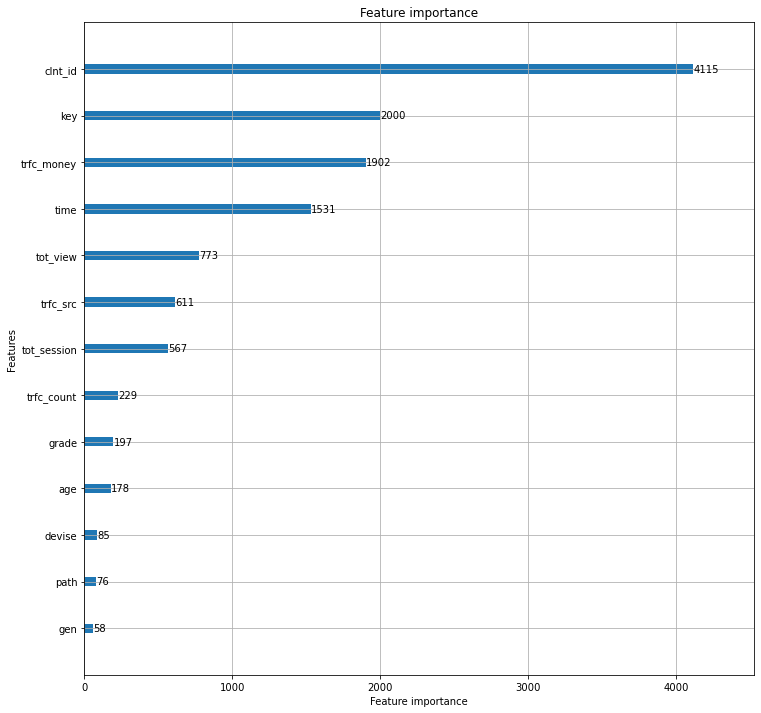

In [201]:
lgb.plot_importance(lgb_model, figsize = (12, 12))

In [202]:
joblib.dump(lgb_model, './Doc_model/lgb_model_final.pkl')

['./Doc_model/lgb_model_final.pkl']

## 모델 정확도 평가

In [203]:
lgb_model = joblib.load('./Doc_model/lgb_model_final.pkl')

In [204]:
test_x = pd.read_csv('./new_data/test_x.csv')
test_y = pd.read_csv('./new_data/test_y.csv')

In [206]:
# 예측 정확도를 측정하기 위해 마련한 고객별 ID 정보 및 실제 구매상품
id_for_test_x = data_df.loc[test_x.index, ['고객', '소분류']].reset_index(drop = True)
id_for_test_x.to_csv('./Doc_model/navigator_for_scoring_id.csv', index = False)

# 데이터 불러오기
id_for_test_x = pd.read_csv('./Doc_model/navigator_for_scoring_id.csv')

In [227]:
# 정확도 측정을 위한 함수
def is_correct(df):
    target_list = df['소분류'].unique()
    for i in df.index:
        if df['pred'].loc[i] in target_list:
            df.loc[i, 'is_correct'] = 1
    return df

In [228]:
pred = lgb_model.predict(test_x)
df_pred = pd.DataFrame(pred).apply(lambda x: x.idxmax(), axis=1)
id_for_test_x.reset_index(drop = True, inplace = True)
id_for_test_x['pred'] = df_pred
id_for_test_x.sort_values(by = ['고객'], inplace = True)
id_for_test_x.reset_index(drop = True, inplace = True)

# is_correct가 0인 경우 오답, is_correct가 1인 경우 정답
id_for_test_x['is_correct'] = 0
output = id_for_test_x.groupby(['고객']).apply(lambda x: is_correct(x))
output[['고객', '소분류', 'pred','is_correct']]

,고객,소분류,pred,is_correct
0,-1.712934,301,108,0
1,-1.712934,22,298,0
2,-1.712934,271,49,0
3,-1.712934,271,108,0
4,-1.712934,75,142,0
...,...,...,...,...
1824,1.757692,92,365,0
1825,1.757692,320,365,0
1826,1.757692,260,365,0
1827,1.757692,224,44,0


In [211]:
print(f"정확도: {output['is_correct'].mean()*100}%")

정확도: 4.702022963367961%
